# Preprocessing

In [2]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup

import spacy 
from spacy.lang.en.stop_words import STOP_WORDS

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm,tqdm_notebook

from  wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# DATA_SET = './datasets/aclimdb.csv'
DATA_SET = './datasets/IMDBDataset.csv'
df_nb_svm =pd.read_csv(DATA_SET)
df_nb_svm.sample(5)

,review,sentiment
42449,What I expected: A rather lame overly-stereoty...,positive
1170,Not to be confused with the Resse Witherspoon ...,positive
25912,"""New Best Friend"" is another entry in the ""ste...",negative
33588,"Certainly not a bad little low budget film, th...",negative
21148,"I am a HUGE Tenacious D fan, and I think this ...",positive


In [4]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
sentiment_label = le.fit_transform(df_nb_svm["sentiment"])
print(le.classes_)
df_nb_svm =df_nb_svm.drop("sentiment",axis="columns")
df_nb_svm["sentiment"] = sentiment_label
df_nb_svm
# negative - 0 , positive - 1

['negative' 'positive']


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [5]:
df_nb_svm['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [6]:
df_nb_svm.shape

(50000, 2)

In [7]:
#lowercasing all the words in the review
df_nb_svm['review']=df_nb_svm['review'].apply(lambda x: x.lower())
df_nb_svm.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. <br /><br />the...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1


In [8]:
#contraction to expansion : 
#converting the words in their contracted form to their extracted form eg. he'll to he will
#using the cont_to_exp() and a dictionary:{key: contractions,value:expansion}
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and "}
def cont_to_exp(x):
    if type(x) is str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key,value)
        return x
    else : 
        return x
df_nb_svm['review'] = df_nb_svm['review'].apply(lambda x:cont_to_exp(x))


In [9]:
df_nb_svm.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. <br /><br />the...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there is a family where a little boy...,0
4,"petter mattei's ""love in the time of money"" is...",1


In [10]:
# Removing the urls from the reviews
df_nb_svm['review']=df_nb_svm['review'].apply(lambda x: re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?','',x)) 
df_nb_svm.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. <br /><br />the...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there is a family where a little boy...,0
4,"petter mattei's ""love in the time of money"" is...",1


In [11]:
# Removal of special characters from the reviews
df_nb_svm['review']=df_nb_svm['review'].apply(lambda x:re.sub(r'[^0-9a-zA-Z *]','',x))

In [12]:
df_nb_svm.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there is a family where a little boy...,0
4,petter matteis love in the time of money is a ...,1


In [13]:
#Removal of mulitple spaces between the words in the review
df_nb_svm["review"]=df_nb_svm["review"].apply(lambda x: " ".join(x.split()))
df_nb_svm.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there is a family where a little boy...,0
4,petter matteis love in the time of money is a ...,1


In [14]:
#Removal of HTML Tags: from the reviews
df_nb_svm['review'] = df_nb_svm['review'].apply(lambda x:BeautifulSoup(x,'lxml').get_text())

In [15]:
df_nb_svm.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there is a family where a little boy...,0
4,petter matteis love in the time of money is a ...,1


In [16]:
#Stopword removal : Stopwords are the words that appear quite frequently in a sentence and do not have a significant contribution to the meaning of the sentence. Therefore they can be removed.
df_nb_svm['review'] = df_nb_svm['review'].apply(lambda x:" ".join([t for t in x.split() if t not in STOP_WORDS ]))

In [17]:
df_nb_svm.head()

,review,sentiment
0,reviewers mentioned watching 1 oz episode youl...,1
1,wonderful little production br br filming tech...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter matteis love time money visually stunni...,1


In [18]:
#word cloud visualization 
df_positive = df_nb_svm[df_nb_svm['sentiment'] == 1]
bag_of_words_positive =' '.join(df_positive['review'])
bag_of_words_positive = bag_of_words_positive.split()

df_negative = df_nb_svm[df_nb_svm['sentiment'] == 0]
bag_of_words_negative =' '.join(df_negative['review'])
bag_of_words_negative = bag_of_words_negative.split()

In [19]:
x = ' '.join(bag_of_words_positive[:20000])
len(bag_of_words_positive)
print(x)

y = ' '.join(bag_of_words_negative[:20000])
len(bag_of_words_negative)
print(y)

reviewers mentioned watching 1 oz episode youll hooked right exactly happened mebr br thing struck oz brutality unflinching scenes violence set right word trust faint hearted timid pulls punches regards drugs sex violence hardcore classic use wordbr br called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements far awaybr br main appeal fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess episode saw struck nasty surreal ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order away mannered middle class inmates turned prison bitches lack street skills prison experience watching oz c

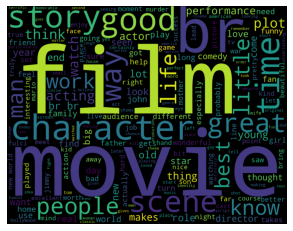

In [20]:
# for positive : 
wc = WordCloud(width=1800,height=1400).generate(x)
plt.imshow(wc)
plt.axis("off")
plt.show()

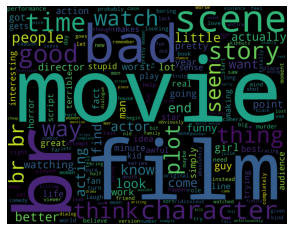

In [21]:
#for negative : 
wc = WordCloud(width=1800,height=1400).generate(y)
plt.imshow(wc)
plt.axis("off")
plt.show()

In [22]:
#sampling 
df_nb_svm0 = df_nb_svm[df_nb_svm['sentiment']==0].sample(2000)
df_nb_svm1 = df_nb_svm[df_nb_svm['sentiment']==1].sample(2000)

df_nb_svm_sampled = df_nb_svm0.append(df_nb_svm1)

#Bag Of Words Representation 
cv = CountVectorizer()

#features 
X_nb_svm = cv.fit_transform(df_nb_svm_sampled['review'])
X_nb_svm.toarray().shape

/tmp/ipykernel_11270/3727288529.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_nb_svm_sampled = df_nb_svm0.append(df_nb_svm1)


(4000, 44496)

In [23]:
y_nb_svm = df_nb_svm_sampled['sentiment']
y_nb_svm.shape

(4000,)

In [24]:
df_nb_svm_bow = pd.DataFrame(X_nb_svm.toarray(),
                               columns=cv.get_feature_names())

/home/neelchoksi19bce0990/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [25]:
df_nb_svm_bow.head()

,0069,007,00s,010,039,03oct2009,04,05,05br,06,...,zucker,zucovic,zugsmith,zula,zulabr,zulu,zurer,zurers,zweite,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# NB SVM Stacking

In [26]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

In [27]:
svm = LinearSVC(random_state=42,max_iter=200)
nb = MultinomialNB()

In [28]:
clf = {'SVM':svm,'NB':nb}

In [29]:
clf.keys()

dict_keys(['SVM', 'NB'])

In [30]:
for key in clf.keys():
  print(clf[key])

LinearSVC(max_iter=200, random_state=42)
MultinomialNB()


In [31]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
#used to center the data
def classify(X,y):
  scaler = MinMaxScaler(feature_range=(0,1))
  X = scaler.fit_transform(X)

  X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42)

  for key in clf.keys():
    clf[key].fit(X_train,y_train)
    y_pred = clf[key].predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    conf_matrix = confusion_matrix(y_test,y_pred)
    print(key,":accuracy : ",accuracy*100)
    print("\n")
    print(key,":confusion_matrix:\n",conf_matrix)
    print("precision:",conf_matrix[0][0]*100/(conf_matrix[0][0]+conf_matrix[1][0]))
    print("recall:",conf_matrix[0][0]*100/(conf_matrix[0][0]+conf_matrix[0][1]))

In [32]:
classify(df_nb_svm_bow,y_nb_svm)

SVM :accuracy :  82.375


SVM :confusion_matrix:
 [[342  80]
 [ 61 317]]
precision: 84.863523573201
recall: 81.04265402843602
NB :accuracy :  80.0


NB :confusion_matrix:
 [[339  83]
 [ 77 301]]
precision: 81.49038461538461
recall: 80.33175355450237


In [33]:
#precision = tp/(tp+fp)
#recall = tp/(tp+fn)

In [35]:
# stacking nb, svm
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression # meta lerner
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(df_nb_svm_bow)
y=y_nb_svm

X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42)
nb =nb.fit(X_train,y_train)

#make predictions 
y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)


#Train set performance 
nb_train_accuracy = accuracy_score(y_train,y_train_pred)
nb_train_mcc = matthews_corrcoef(y_train,y_train_pred)
nb_train_f1 = f1_score(y_train,y_train_pred,average="weighted")

#Test set performance
nb_test_accuracy = accuracy_score(y_test,y_test_pred)
nb_test_mcc = matthews_corrcoef(y_test,y_test_pred)
nb_test_f1 = f1_score(y_test,y_test_pred,average="weighted")



svm = svm.fit(X_train,y_train)
#make predictions 
y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)


#Train set performance 
svm_train_accuracy = accuracy_score(y_train,y_train_pred)
svm_train_mcc = matthews_corrcoef(y_train,y_train_pred)
svm_train_f1 = f1_score(y_train,y_train_pred,average="weighted")

#Test set performance
svm_test_accuracy = accuracy_score(y_test,y_test_pred)
svm_test_mcc = matthews_corrcoef(y_test,y_test_pred)
svm_test_f1 = f1_score(y_test,y_test_pred,average="weighted")


estimator_list = [
    ('nb',nb),
    ('svm',svm),
]

#build stack model 
stack_model = StackingClassifier(
    estimators = estimator_list, final_estimator = LogisticRegression()
)

#train stacked model 
stack_model.fit(X_train,y_train)

#make predictions
y_train_pred = stack_model.predict(X_train)
y_test_pred = stack_model.predict(X_test)

#training set model performance
#Train set performance 
stack_model_train_accuracy = accuracy_score(y_train,y_train_pred)
stack_model_train_mcc = matthews_corrcoef(y_train,y_train_pred)
stack_model_train_f1 = f1_score(y_train,y_train_pred,average="weighted")


#Test set performance
stack_model_test_accuracy = accuracy_score(y_test,y_test_pred)
stack_model_test_mcc = matthews_corrcoef(y_test,y_test_pred)
stack_model_test_f1 = f1_score(y_test,y_test_pred,average="weighted")

#stacking model train accuracies : 
# print("stack_model : train accuracies")
# print ("accuracy %s" % stack_model_train_accuracy)
# print("matthews corr coef : %s" %stack_model_train_mcc)
# print("f1 score : %s" %stack_model_train_f1)

#stacking model test accuracies:
# print("stack_model : test accuracies")
# print ("accuracy %s" % stack_model_test_accuracy)
# print("matthews corr coef : %s" %stack_model_test_mcc)
# print("f1 score : %s" %stack_model_test_f1)


acc_train_list = {
    'nb':nb_train_accuracy,
    'svm':svm_train_accuracy,
    'stack':stack_model_train_accuracy
}

mcc_train_list = {
    'nb':nb_train_mcc,
    'svm':svm_train_mcc,
    'stack':stack_model_train_mcc
}

f1_train_list={
    'nb':nb_train_f1,
    'svm':svm_train_f1,
    'stack':stack_model_train_f1
}
print("Training Accuracies")
acc_df = pd.DataFrame.from_dict(acc_train_list,orient="index",columns=['Accuracy'])
mcc_df = pd.DataFrame.from_dict(mcc_train_list,orient="index",columns=['MCC'])
f1_df = pd.DataFrame.from_dict(f1_train_list,orient="index",columns=['F1'])
stack_df = pd.concat([acc_df,mcc_df,f1_df],axis = 1)
stack_df


/home/neelchoksi19bce0990/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/neelchoksi19bce0990/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Accuracies


,Accuracy,MCC,F1
nb,0.991563,0.983122,0.991563
svm,1.000000,1.000000,1.000000
stack,1.000000,1.000000,1.000000


In [36]:
print("Testing accuracies")
acc_test_list = {
    'nb':nb_test_accuracy,
    'svm':svm_test_accuracy,
    'stack':stack_model_test_accuracy
}

mcc_test_list = {
    'nb':nb_test_mcc,
    'svm':svm_test_mcc,
    'stack':stack_model_test_mcc
}

f1_test_list={
    'nb':nb_test_f1,
    'svm':svm_test_f1,
    'stack':stack_model_test_f1
}
acc_df_test = pd.DataFrame.from_dict(acc_test_list,orient="index",columns=['Accuracy'])
mcc_df_test = pd.DataFrame.from_dict(mcc_test_list,orient="index",columns=['MCC'])
f1_df_test = pd.DataFrame.from_dict(f1_test_list,orient="index",columns=['F1'])
stack_df_test = pd.concat([acc_df_test,mcc_df_test,f1_df_test],axis = 1)
stack_df_test


Testing accuracies


,Accuracy,MCC,F1
nb,0.80000,0.599186,0.800071
svm,0.82375,0.648087,0.823881
stack,0.83625,0.671926,0.836316


# Bag of Words Feed Forward Model

In [37]:
class Sequences(Dataset):
    def __init__(self,path):
        df = df_nb_svm

        self.vectorizer = CountVectorizer(stop_words='english', max_df = 0.99 , min_df = 0.005)
        self.sequences = self.vectorizer.fit_transform(df.review.tolist())
        self.labels = df.sentiment.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token , idx in self.token2idx.items()}
    def __getitem__(self,i):
        return self.sequences[i, :].toarray(), self.labels[i]
    def __len__(self):
        return self.sequences.shape[0]        

In [38]:
ff_bow_db = Sequences(DATA_SET)
ff_bow_train_loader = DataLoader(ff_bow_db, batch_size = 4096)

In [39]:
print(ff_bow_db.sequences)

  (0, 2042)	1
  (0, 1572)	1
  (0, 2698)	2
  (0, 809)	2
  (0, 2793)	1
  (0, 1204)	1
  (0, 2050)	2
  (0, 834)	1
  (0, 1134)	1
  (0, 1555)	1
  (0, 300)	3
  (0, 2497)	1
  (0, 2361)	2
  (0, 2116)	1
  (0, 2660)	4
  (0, 2169)	1
  (0, 2760)	1
  (0, 2575)	1
  (0, 1924)	1
  (0, 743)	1
  (0, 2175)	1
  (0, 441)	1
  (0, 2627)	1
  (0, 342)	1
  (0, 1061)	1
  :	:
  (49999, 251)	1
  (49999, 1075)	1
  (49999, 2770)	1
  (49999, 1629)	3
  (49999, 2307)	1
  (49999, 901)	1
  (49999, 2573)	1
  (49999, 391)	1
  (49999, 2101)	1
  (49999, 1381)	1
  (49999, 2610)	1
  (49999, 1425)	1
  (49999, 850)	1
  (49999, 202)	1
  (49999, 1141)	1
  (49999, 1663)	1
  (49999, 1262)	1
  (49999, 902)	1
  (49999, 162)	1
  (49999, 2563)	1
  (49999, 2017)	1
  (49999, 810)	1
  (49999, 339)	1
  (49999, 1077)	1
  (49999, 2015)	1


In [40]:
print(ff_bow_db.sequences[0].shape)

(1, 2802)


In [41]:
print(len(ff_bow_db.labels))
print(ff_bow_db.labels)

50000
[1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 

In [42]:
print(len(ff_bow_db.token2idx))
print(ff_bow_db.token2idx)

2802
{'reviewers': 2042, 'mentioned': 1572, 'watching': 2698, 'episode': 809, 'youll': 2793, 'hooked': 1204, 'right': 2050, 'exactly': 834, 'happened': 1134, 'mebr': 1555, 'br': 300, 'thing': 2497, 'struck': 2361, 'scenes': 2116, 'violence': 2660, 'set': 2169, 'word': 2760, 'trust': 2575, 'pulls': 1924, 'drugs': 743, 'sex': 2175, 'classic': 441, 'use': 2627, 'called': 342, 'given': 1061, 'security': 2142, 'state': 2315, 'focuses': 980, 'mainly': 1513, 'city': 436, 'section': 2141, 'prison': 1884, 'glass': 1065, 'face': 876, 'high': 1178, 'home': 1200, 'irish': 1307, 'death': 622, 'far': 905, 'main': 1512, 'appeal': 145, 'fact': 879, 'goes': 1069, 'shows': 2202, 'wouldnt': 2774, 'dare': 603, 'forget': 998, 'pretty': 1874, 'pictures': 1807, 'mainstream': 1514, 'audiences': 196, 'charm': 402, 'mess': 1575, 'saw': 2105, 'nasty': 1650, 'surreal': 2424, 'ready': 1964, 'watched': 2697, 'developed': 669, 'taste': 2450, 'got': 1082, 'levels': 1438, 'graphic': 1091, 'sold': 2254, 'kill': 1365, '

In [43]:
print(len(ff_bow_db.idx2token))
print(ff_bow_db.idx2token)

2802
{2042: 'reviewers', 1572: 'mentioned', 2698: 'watching', 809: 'episode', 2793: 'youll', 1204: 'hooked', 2050: 'right', 834: 'exactly', 1134: 'happened', 1555: 'mebr', 300: 'br', 2497: 'thing', 2361: 'struck', 2116: 'scenes', 2660: 'violence', 2169: 'set', 2760: 'word', 2575: 'trust', 1924: 'pulls', 743: 'drugs', 2175: 'sex', 441: 'classic', 2627: 'use', 342: 'called', 1061: 'given', 2142: 'security', 2315: 'state', 980: 'focuses', 1513: 'mainly', 436: 'city', 2141: 'section', 1884: 'prison', 1065: 'glass', 876: 'face', 1178: 'high', 1200: 'home', 1307: 'irish', 622: 'death', 905: 'far', 1512: 'main', 145: 'appeal', 879: 'fact', 1069: 'goes', 2202: 'shows', 2774: 'wouldnt', 603: 'dare', 998: 'forget', 1874: 'pretty', 1807: 'pictures', 1514: 'mainstream', 196: 'audiences', 402: 'charm', 1575: 'mess', 2105: 'saw', 1650: 'nasty', 2424: 'surreal', 1964: 'ready', 2697: 'watched', 669: 'developed', 2450: 'taste', 1082: 'got', 1438: 'levels', 1091: 'graphic', 2254: 'sold', 1365: 'kill', 1

In [44]:
print(ff_bow_db[5][0].shape)

(1, 2802)


In [45]:
# feed forward 1 : bow neural network 
class BoWFF1(nn.Module):
    def __init__(self,vocab_size,hidden1,hidden2):
        super(BoWFF1,self).__init__()
        self.fc1 = nn.Linear(vocab_size,hidden1)
        self.fc2 = nn.Linear(hidden1,hidden2)
        self.fc3 = nn.Linear(hidden2,1)
        
    def forward(self,inputs):
        x = F.relu(self.fc1(inputs.squeeze(1).float()))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [47]:
model_ff_bow = BoWFF1(len(ff_bow_db.idx2token),128,64)
model_ff_bow

BoWFF1(
  (fc1): Linear(in_features=2802, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [48]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam([p for p in model_ff_bow.parameters() if p.requires_grad],lr=0.001)

In [50]:
model_ff_bow.train()
train_losses = [] 
for epoch in range(10):
    progress_bar = tqdm_notebook(ff_bow_train_loader,leave=False)
    losses = []
    total = 0
    for inputs,target in progress_bar:
        model_ff_bow.zero_grad()
        
        output = model_ff_bow(inputs)
        loss = criterion(output.squeeze(), target.float())
        
        loss.backward()
              
        nn.utils.clip_grad_norm_(model_ff_bow.parameters(), 3)

        optimizer.step()
        
        progress_bar.set_description(f'Loss: {loss.item():.3f}')
        
        losses.append(loss.item())
        total += 1
    
    epoch_loss = sum(losses) / total
    train_losses.append(epoch_loss)
        
    tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')

/tmp/ipykernel_11270/3886666268.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(ff_bow_train_loader,leave=False)


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch #1	Train Loss: 0.621


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch #2	Train Loss: 0.395


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch #3	Train Loss: 0.289


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch #4	Train Loss: 0.261


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch #5	Train Loss: 0.249


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch #6	Train Loss: 0.243


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch #7	Train Loss: 0.238


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch #8	Train Loss: 0.235


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch #9	Train Loss: 0.231


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch #10	Train Loss: 0.229


In [53]:
def predict_sentiment(text):
    model_ff_bow.eval()
    with torch.no_grad():
        test_vector = torch.LongTensor(ff_bow_db.vectorizer.transform([text]).toarray())

        output = model_ff_bow(test_vector)
        prediction = torch.sigmoid(output).item()

        if prediction > 0.5:
            print(f'{prediction:0.3}: Positive sentiment')
        else:
            print(f'{prediction:0.3}: Negative sentiment')

In [54]:
test_text = """
The ground maintainance was horrible and the staff was not cooperative
"""
predict_sentiment(test_text)

0.314: Negative sentiment


# Embedding RNN GRU LSTM Model

In [55]:
import pandas as pd
import torch 
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer
from torch.nn.utils.rnn import pack_padded_sequence,pad_packed_sequence
from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm,tqdm_notebook
from sklearn import preprocessing

In [56]:
class SequencesRNN(Dataset):
    def __init__(self,path,max_seq_len):
        self.max_seq_len = max_seq_len
        df = df_nb_svm
       
        vectorizer = CountVectorizer(stop_words="english",min_df=0.015)
        vectorizer.fit(df.review.tolist())
        
        self.token2idx = vectorizer.vocabulary_
        self.token2idx['<PAD>'] = max(self.token2idx.values())+1
        
        tokenizer = vectorizer.build_analyzer()
        self.encode = lambda x:[self.token2idx[token] for token in tokenizer(x) if token in self.token2idx]
        self.pad = lambda x: x + (max_seq_len - len(x)) * [self.token2idx['<PAD>']]
        
        sequences = [self.encode(sequence)[:max_seq_len] for sequence in df.review.tolist()]
        sequences,self.labels = zip(*[(sequence,label) for sequence,label in zip(sequences, df.sentiment.tolist()) if sequence])
        
        self.sequences = [self.pad(sequence) for sequence in sequences]
        
    def __getitem__(self,i):
        assert len(self.sequences[i]) == self.max_seq_len
        return self.sequences[i], self.labels[i]
    
    def __len__(self):
        return len(self.sequences)

In [57]:
datasetRNN = SequencesRNN(DATA_SET,max_seq_len = 128)

In [58]:
len(datasetRNN.sequences)

49999

In [59]:
len(datasetRNN.token2idx)

977

In [60]:
def collate(batch):
    inputs = torch.LongTensor([item[0] for item in batch])
    target = torch.FloatTensor([item[1] for item in batch])
    return inputs,target

batch_size = 2048
train_loader = DataLoader(datasetRNN,batch_size= batch_size,collate_fn = collate)

In [61]:
class GRU(nn.Module):
    def __init__(self, vocab_size,batch_size,embedding_dimension=100,hidden_size = 128, n_layers = 1, device = 'cpu'):
        super(GRU,self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size 
        self.device = device
        self.batch_size = batch_size
        
        self.encoder = nn.Embedding(vocab_size,embedding_dimension)
        self.gru = nn.GRU(
            embedding_dimension,
            hidden_size,
            num_layers = n_layers,
            batch_first = True,
        )
        self.decoder = nn.Linear(hidden_size,1)
        
    def init_hidden(self):
        return torch.randn(self.n_layers,self.batch_size,self.hidden_size)

    def forward(self,inputs):
        batch_size = inputs.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size

        encoded = self.encoder(inputs)
        output, hidden = self.gru(encoded,self.init_hidden())
        output = self.decoder(output[:,:,-1]).squeeze()
        return output 

In [62]:
device = 'cpu'
model_GRU = GRU(
    hidden_size = 128,
    vocab_size = len(datasetRNN.token2idx),
    device= device,
    batch_size = batch_size
)
model_GRU = model_GRU.to(device)
model_GRU

GRU(
  (encoder): Embedding(977, 100)
  (gru): GRU(100, 128, batch_first=True)
  (decoder): Linear(in_features=128, out_features=1, bias=True)
)

In [63]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam([p for p in model_GRU.parameters() if p.requires_grad], lr = 0.001)

In [64]:
model_GRU.train()
train_losses = []
for epoch in range(10):
    progress_bar = tqdm_notebook(train_loader,leave=False)
    losses = []
    total = 0 
    for inputs,target in progress_bar:
        inputs,target = inputs.to(device), target.to(device)
        model_GRU.zero_grad()
        output = model_GRU(inputs)
        loss = criterion(output,target)
        loss.backward()
        nn.utils.clip_grad_norm_(model_GRU.parameters(),3)
        optimizer.step()
        progress_bar.set_description(f'Loss:{loss.item():.3f}')
        losses.append(loss.item())
        total += 1
        
    epoch_loss = sum(losses)/total
    train_losses.append(epoch_loss)
    
    tqdm.write(f'Epoch #{epoch + 1}\t Train Loss : {epoch_loss:.3f}')

/tmp/ipykernel_11270/2404735744.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(train_loader,leave=False)


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #1	 Train Loss : 0.682


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #2	 Train Loss : 0.551


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #3	 Train Loss : 0.434


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #4	 Train Loss : 0.382


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #5	 Train Loss : 0.351


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #6	 Train Loss : 0.336


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #7	 Train Loss : 0.324


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #8	 Train Loss : 0.317


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #9	 Train Loss : 0.311


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #10	 Train Loss : 0.305


In [66]:
def predict_sentimentGRU(text):
    model_GRU.eval()
    with torch.no_grad():
        test_vector = torch.LongTensor([datasetRNN.pad(datasetRNN.encode(text))])
        
        output = model_GRU(test_vector)
        prediction = torch.sigmoid(output).item()
        
        if prediction > 0.5:
            print(f'{prediction:0.3}: Positive sentiment')
        else : 
            print(f'{prediction:0.3}: Negative sentiment')

In [67]:
test_text = """
The ground maintainance was horrible and the staff was not cooperative
"""
predict_sentimentGRU(test_text)

0.197: Negative sentiment


# Voting(Stacking) , Boosting , Bagging ,Fusion Model

In [68]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms

from torchensemble import VotingClassifier
from torchensemble import FusionClassifier
from torchensemble import BaggingClassifier
from torchensemble import GradientBoostingClassifier

from torchensemble.utils.logging import set_logger

In [72]:
train_loader = DataLoader(datasetRNN,batch_size= batch_size,shuffle=True)
# test_loader = DataLoader()
logger = set_logger('textClassification_gru')


model_voting = VotingClassifier(
    estimator = GRU,
    n_estimators = 5,
    cuda = False
)

criterion = nn.CrossEntropyLoss()
model_voting.set_criterion(criterion)

model_voting.set_optimizer('Adam',lr = 1e-3, weight_decay=5e-4)

model_voting.fit(
    train_loader=train_loader,
    epochs=5,
    test_loader = train_loader,
)



Log will be saved in '/home/neelchoksi19bce0990/Documents/NeelVITCurrSem/sem6/proj/cse1901/SEM6_TARP/implementation/logs'.
Start logging into file /home/neelchoksi19bce0990/Documents/NeelVITCurrSem/sem6/proj/cse1901/SEM6_TARP/implementation/logs/textClassification_gru-2022_04_20_02_03.log...


AttributeError: 'list' object has no attribute 'to'

In [ ]:
train_loader = DataLoader(datasetRNN,batch_size= batch_size,shuffle=True)
# test_loader = DataLoader()
logger = set_logger('textClassification_gru')


model_fusion = FusionClassifier(
    estimator = GRU,
    n_estimators = 5,
    cuda = False
)

criterion = nn.CrossEntropyLoss()
model_fusion.set_criterion(criterion)

model_fusion.set_optimizer('Adam',lr = 1e-3, weight_decay=5e-4)

model_fusion.fit(
    train_loader=train_loader,
    epochs=5,
    test_loader = train_loader,
)



In [ ]:
train_loader = DataLoader(datasetRNN,batch_size= batch_size,shuffle=True)
# test_loader = DataLoader()
logger = set_logger('textClassification_gru')


model_bagging = BaggingClassifier(
    estimator = GRU,
    n_estimators = 5,
    cuda = False
)

criterion = nn.CrossEntropyLoss()
model_bagging.set_criterion(criterion)

model_bagging.set_optimizer('Adam',lr = 1e-3, weight_decay=5e-4)

model_bagging.fit(
    train_loader=train_loader,
    epochs=5,
    test_loader = train_loader,
)

In [ ]:
train_loader = DataLoader(datasetRNN,batch_size= batch_size,shuffle=True)
# test_loader = DataLoader()
logger = set_logger('textClassification_gru')


model_gb = GradientBoostingClassifier(
    estimator = GRU,
    n_estimators = 5,
    cuda = False
)

criterion = nn.CrossEntropyLoss()
model_gb.set_criterion(criterion)

model_gb.set_optimizer('Adam',lr = 1e-3, weight_decay=5e-4)

model_gb.fit(
    train_loader=train_loader,
    epochs=5,
    test_loader = train_loader,
)

